# Element Parameter Detection

## Setup

In [1]:
%load_ext autoreload

import numpy as np
import math
import random
import os
import os.path
import torch
import sys
import copy
import pickle
import importlib
import torch.nn as nn
import time
import functorch
from numpy.random import default_rng
from tqdm.notebook import tqdm
from ipywidgets import interact 
import gc

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from chamferdist import ChamferDistance
from pathlib import Path

import ifcopenshell
import open3d as o3d

from src.elements import *
from src.ifc import *
from src.preparation import *
from src.dataset import *
from src.pointnet import *
from src.visualisation import *
from src.geometry import sq_distance, get_oriented_bbox_from_points
from src.icp import icp_finetuning
from src.chamfer import *
from src.utils import *
from src.plots import plot_error_graph, plot_parameter_errors
from src.pca import testset_PCA
from src.finetune import chamfer_fine_tune, mahalanobis_fine_tune
from src.cloud import add_noise

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loaded JIT 3D CUDA emd


In [2]:
random.seed = 42
rng = default_rng()

In [3]:
# path = Path("ModelNet10")
# path = Path('/content/drive/MyDrive/ElementNet/')
path = Path("output/")
# savepath = '/content/drive/MyDrive/ElementNet/'
savepath = "models/"
cuda = torch.device("cuda")

noise = False

In [4]:
blueprint = "data/sample.ifc"
temp_dir = "output/temp/"
target_dir = "output/tee/test/"

ifcConvert_executable = "scripts/./IfcConvert"
cloudCompare_executable = "cloudcompare.CloudCompare"
sample_size = 2048
threshold = 2

## Model

## Test

Analyze results statistically

POINTNET++

In [5]:
train_transforms = transforms.Compose(
    [
        Normalize(),
        #                    RandomNoise(),
        ToTensor(),
    ]
)

In [6]:
# load data and model
BASE_DIR = os.path.dirname(os.path.abspath("industrial-facility-relationships/"))
BASE_DIR = os.path.join(BASE_DIR, "pointnet2")
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, "models"))

inference = True
cloi = True

if cloi:
    return_coefficients = True

if inference:
    if cloi:
        path = Path("cloi/")
        ext = ".pcd"
    else:
        #     path = Path('output/bp_data/')
        # path = Path('output/east_ref/')
        path = Path("occluded/west/")
        # path = Path('output/')

        # path = Path('/mnt/c/data/3D_CAD/east_clouds/')
        ext = ".pcd"

else:
    if not noise:
        # path = Path("occluded/")
        path = Path("output/")
    else:
        path = Path("output/noisy/")
    ext = ".pcd"

cat = "pipe"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_normals = False
cat_targets = {"elbow": 14, "bend": 14, "tee": 19, "pipe": 11, "flange": 13}

if inference:

    test_ds = PointCloudData(
        path,
        valid=True,
        folder="test",
        category=cat,
        transform=train_transforms,
        inference=True,
        return_coefficients=return_coefficients,
    )
    targets = cat_targets[cat]
else:
    test_ds = PointCloudData(
        path, valid=True, folder="test", category=cat, transform=train_transforms
    )
    targets = test_ds.targets

testDataLoader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=128)
test_criterion = nn.MSELoss()

model_name = "pointnet2_cls_ssg"
model_path = Path("pointnet2/log/classification/pointnet2_cls_ssg/")
model = importlib.import_module(model_name)


predictor = model.get_model(targets, normal_channel=use_normals)
if device != "cpu":
    predictor = predictor.cuda()

# checkpoint = torch.load(model_path/'checkpoints/best_model.pth')
checkpoint = torch.load(model_path / "checkpoints/models/best_model_p_chamfer_0005.pth")
# checkpoint = torch.load(model_path/'checkpoints/models/best_model_t_chamfer_00005_bp.pth')
predictor.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [7]:
def model_inference(
    model, loader, device, calculate_score=False, return_coefficients=False
):
    predictor = model.eval()
    predictions_list, pcd_list, id_list, mean_list, norm_factor_list = (
        [],
        [],
        [],
        [],
        [],
    )
    with torch.no_grad():
        for j, data in tqdm(enumerate(loader), total=len(loader)):
            if return_coefficients:
                points, ids, mean, norm_factor = (
                    data["pointcloud"].to(device).float(),
                    data["id"].to(device),
                    data["mean"].to(device),
                    data["norm_factor"].to(device),
                )
            else:
                points, ids = data["pointcloud"].to(device).float(), data["id"].to(
                    device
                )
            points = points.transpose(2, 1)
            preds, _ = predictor(points)
            preds, points, ids = (
                preds.to(torch.device("cpu")),
                points.to(torch.device("cpu")),
                data["id"].to(torch.device("cpu")),
            )
            if return_coefficients:
                mean = mean.to(torch.device("cpu"))
                norm_factor = norm_factor.to(torch.device("cpu"))

            for i, pr in enumerate(preds):
                predictions_list.append(pr.numpy())
                pcd_list.append(points[i].numpy())
                id_list.append(ids[i].numpy())

                if return_coefficients:
                    mean_list.append(mean[i].numpy())
                    norm_factor_list.append(norm_factor[i].numpy())

        if return_coefficients:
            return (predictions_list, pcd_list, id_list, mean_list, norm_factor_list)
        return (predictions_list, pcd_list, id_list)

In [8]:
if inference:

    if return_coefficients:
        predictions_list, cloud_list, id_list, mean_list, norm_factor_list = (
            model_inference(
                predictor.eval(), testDataLoader, device, return_coefficients=True
            )
        )
        print(norm_factor_list)
    else:
        predictions_list, cloud_list, id_list = model_inference(
            predictor.eval(), testDataLoader, device
        )

  0%|          | 0/5 [00:00<?, ?it/s]

[array(0.07389313), array(2.13234067), array(0.22522601), array(0.36931056), array(0.05797969), array(1.65387986), array(0.30876321), array(0.05099522), array(3.76758025), array(0.26030933), array(0.05498373), array(0.3343181), array(0.08453427), array(0.46919234), array(1.02377423), array(0.07961651), array(0.09985982), array(0.68537167), array(2.97428626), array(0.11773502), array(0.3750974), array(2.66750426), array(0.32426855), array(0.28989929), array(0.37250276), array(0.23132279), array(0.26331694), array(0.33509887), array(0.08632113), array(0.55050818), array(1.29513084), array(2.87757415), array(0.04966012), array(0.18560093), array(2.57665728), array(1.01780275), array(0.11518165), array(0.18218543), array(0.11125478), array(0.5020538), array(0.5466019), array(1.08247934), array(0.30339713), array(0.18580898), array(0.08014791), array(1.0462482), array(0.97836388), array(0.16618831), array(0.15038199), array(0.0380723), array(0.27728519), array(1.2055983), array(0.19709039),

In [9]:
def test(model, loader, device, criterion):
    losses = []
    predictor = model.eval()
    cloud_list = []
    label_list = []
    output_list = []
    predictions_list = []
    inputs_list = []
    id_list = []
    parameter_id = 0
    tot = 0
    count = 0

    for j, data in tqdm(enumerate(loader), total=len(loader)):
        inputs, labels, ids = (
            data["pointcloud"].to(device).float(),
            data["properties"].to(device),
            data["id"].to(device),
        )
        points, target, ids = (
            data["pointcloud"].to(device).float(),
            data["properties"].to(device),
            data["id"].to(device),
        )
        points = points.transpose(2, 1)
        outputs, _ = predictor(points)
        outputs = outputs.to(torch.device("cpu"))
        inputs = points.to(torch.device("cpu"))
        labels = target.to(torch.device("cpu"))
        ids = ids.to(torch.device("cpu"))
        # print(data['pointcloud'].size(), labels.size(), outputs.size())

        for i in range(outputs.size(0)):
            label_list.append(labels[i].numpy())
            id_list.append(ids[i].item())
            output_list.append(outputs[i][parameter_id].item())
            predictions_list.append(outputs[i].numpy())
            inputs_list.append(labels[i].numpy())
            cloud_list.append(inputs[i].numpy())
            ratio = (
                (labels[i][parameter_id] - outputs[i][parameter_id])
                / labels[i][parameter_id]
            ).item()
            # print('r', i+count, ids[i].item(), labels[i][parameter_id].item(), outputs[i][parameter_id].item(), ratio)
            tot += np.absolute(ratio)
            # print('l', labels[i][1].item(), outputs[i][1].item(), ((labels[i][1]-outputs[i][1])/labels[i][1]).item())

        count += outputs.size(0)
    print(tot / count)

    return predictions_list, inputs_list, label_list, output_list, id_list, cloud_list

In [10]:
if not inference:
    with torch.no_grad():
        (
            predictions_list,
            inputs_list,
            label_list,
            output_list,
            id_list,
            cloud_list,
        ) = test(predictor.eval(), testDataLoader, device, test_criterion)

    print(len(predictions_list), len(inputs_list))

In [11]:
if not inference:
    label_list, output_list, id_list = (
        np.array(label_list),
        np.array(output_list),
        np.array(id_list),
    )

In [12]:
# print(label_list[:10], len(label_list))

In [13]:
# fix negative radii, result of training on noisy data. TODO: figure out why?
for i in range(len(predictions_list)):
    predictions_list[i][0] = abs(predictions_list[i][0])

In [14]:
# print([p[0] for p in label_list])

In [15]:
# print([p[0] for p in predictions_list])

In [16]:
torch.cuda.empty_cache()
gc.collect()

30

#### Visually analyse predictions and Fine tune with ICP, calculate chamfer distances

In [17]:
# evaluate chamfer distance for set of results
def chamfer_evaluate(predictions_list, cloud_list, cat):
    cuda = torch.device("cuda")
    preds_t = torch.tensor(
        predictions_list, requires_grad=True, device=cuda, dtype=torch.float
    )
    cloud_t = torch.tensor(cloud_list, device=cuda, dtype=torch.float)

    chamfer_dists = get_chamfer_loss_tensor(preds_t, cloud_t, cat, reduce=False)
    chamfer_dists = chamfer_dists.detach().cpu().numpy()

    return chamfer_dists


# # scaling up and down is required for icp calculations
# def chamfer_evaluate_with_icp(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
#                      cloudCompare_executable, temp_dir, target_dir, sample_size,
#                      threshold, icp_correction = False):

#     preds_list, pcd_list = [], []
#     error_count = 0

#     # get predictions and pcds
#     for i in tqdm(range(len(predictions_list))):
#     #for i in tqdm(range(50)):
#         pcd_id = id_list[i]
#         pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
#         #print(preds, inputs_list[i])

#         preds = scale_preds(preds.tolist(), cat)
#         #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)

#         try:
#             if  icp_correction:
#                 # note: preds are updated in place during ICP
#                 _, _ = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir,
#                                      ifcConvert_executable, cloudCompare_executable, sample_size, threshold, False)

#             preds_list.append(preds)
#             pcd_list.append(pcd)

#         except Exception as e:
#             print("ICP error", pcd_id, e)
#             error_count += 1

#     # calculate chamfer distances
#     cuda = torch.device('cuda')
#     rescaled_preds = [scale_preds(preds, cat, up=0) for preds in preds_list]
#     preds_t = torch.tensor(rescaled_preds, requires_grad=True, device=cuda)
#     cloud_t = torch.tensor(cloud_list, device=cuda)

#     chamfer_dists = get_chamfer_loss_tensor(preds_t, cloud_t, cat, reduce=False)
#     chamfer_dists = chamfer_dists.detach().cpu().numpy()

#     print("error_count", error_count)
#     return chamfer_dists

/tmp/ipykernel_868119/742723477.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/utils/tensor_new.cpp:230.)
  preds_t = torch.tensor(


avg 46.789997 5 410.7934 1.5703772


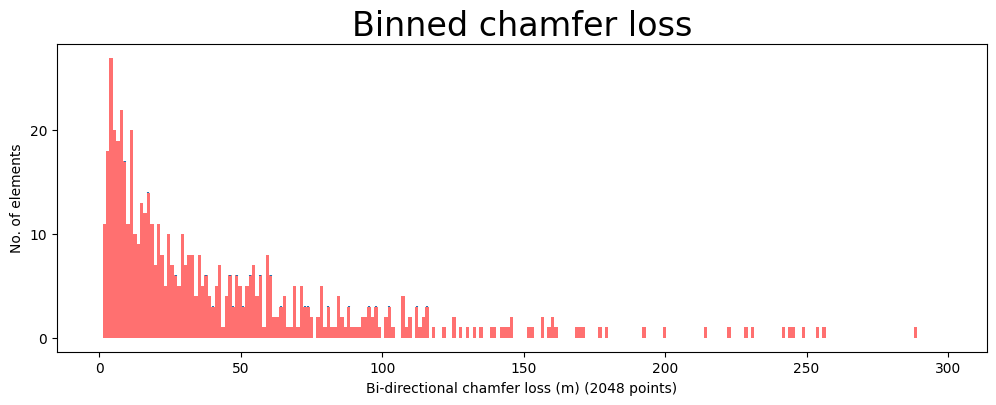

In [18]:
# dists = chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
#                      cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)
dists = chamfer_evaluate(predictions_list, cloud_list, cat)
# if inference:
#     with open(model_path + 'preds_' + cat + '.pkl', 'wb') as f:
#         pickle.dump([predictions_list, id_list, dists], f)

plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [19]:
# scaling up and down is required for icp calculations
def _visualise_predictions(
    predictions_list,
    cloud_list,
    id_list,
    cat,
    blueprint,
    ifcConvert_executable,
    cloudCompare_executable,
    temp_dir,
    target_dir,
    sample_size,
    threshold,
    icp_correction=False,
):
    preds_list, pcd_list = [], []
    viewer_list, ifc_list = [], []
    error_count = 0

    # get predictions and pcds
    # for i in tqdm(range(len(predictions_list))):
    for i in tqdm(range(50)):
        try:
            pcd_id = id_list[i].item()
            pcd, preds = cloud_list[i].transpose(1, 0).tolist(), copy.deepcopy(
                predictions_list[i]
            )
            # print(preds, inputs_list[i])

            preds = scale_preds(preds.tolist(), cat)
            # print(preds)
            # pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, ext)

            #         try:
            if icp_correction:
                # note: preds are updated in place during ICP
                viewer, ifc = icp_finetuning(
                    o3d.utility.Vector3dVector(pcd),
                    pcd_id,
                    cat,
                    preds,
                    blueprint,
                    temp_dir,
                    target_dir,
                    ifcConvert_executable,
                    cloudCompare_executable,
                    sample_size,
                    threshold,
                    True,
                )
            else:
                # print(type(preds[0]))
                # print("lp", preds)
                viewer, ifc = visualize_predictions(
                    [pcd], cat, [preds], blueprint, visualize=True
                )

            preds_list.append(preds)
            pcd_list.append(pcd)
            viewer_list.append(viewer)
            ifc_list.append(ifc)

        except Exception as e:
            print(" error", pcd_id, e)
            error_count += 1

    print("error_count", error_count)
    return viewer_list

In [20]:
print(label_list[0])

NameError: name 'label_list' is not defined

In [ ]:
viewers = _visualise_predictions(
    predictions_list,
    cloud_list,
    id_list,
    cat,
    blueprint,
    ifcConvert_executable,
    cloudCompare_executable,
    temp_dir,
    target_dir,
    sample_size,
    threshold,
    icp_correction=False,
)

In [ ]:
for v in viewers:
    print(v)

In [ ]:
# plot_parameter_errors(inputs_list, predictions_list, cat)

#### BP data Visualisation

In [ ]:
# batch_visualise(model_path, blueprint, path, ext, device, ifc=False)

In [ ]:
# merge_clouds(path, 'pipe')

#### visualise robust loss

In [ ]:
target_pcd_tensor = get_shape_cloud_tensor(
    torch.tensor([predictions_list[0]], device=cuda), cat
)

# visaulise clouds
source = o3d.geometry.PointCloud()
tgt = o3d.geometry.PointCloud()
robust = o3d.geometry.PointCloud()

tgt.points = o3d.utility.Vector3dVector(
    target_pcd_tensor[0].detach().cpu().numpy().astype(np.double)
)
source.points = o3d.utility.Vector3dVector(cloud_list[0].transpose())

source.paint_uniform_color([0.0, 0.706, 1])
tgt.paint_uniform_color([0.7, 0.70, 0])

o3d.visualization.draw_geometries([tgt])

In [ ]:
%autoreload 2

loss, non_robust_fwd, non_robust_bwd = calc_robust_chamfer_loss_tensor(torch.tensor([cloud_list[0].transpose()], device=cuda), target_pcd_tensor)
print(non_robust_bwd.shape)

In [ ]:
source.points = o3d.utility.Vector3dVector(cloud_list[0].transpose())
tgt.points = o3d.utility.Vector3dVector(
    target_pcd_tensor[0].detach().cpu().numpy().astype(np.double)
)
robust.points = o3d.utility.Vector3dVector(
    non_robust_bwd.detach().cpu().numpy().astype(np.double)
)

source.paint_uniform_color([0.0, 0.706, 1])
tgt.paint_uniform_color([0.7, 0.70, 0])
robust.paint_uniform_color([1, 0.0, 0.0])

o3d.visualization.draw_geometries([source, tgt, robust])

### fine tuning

In [21]:
print(len(predictions_list))
vis = 0

print(cat)

if cat == "elbow":
    elbow_fix = False
else:
    elbow_fix = True

if cat == "bend":
    cat = "elbow"

limit = 64

583
pipe


#### mahalanobis

In [ ]:
# load gmm parameters
gmm_path = Path("gaussians/gaussians_128.pkl")
with open(gmm_path, "rb") as f:
    means, covs, gmm_ids, weights = pickle.load(f)
    # means, covs = torch.tensor(means).cuda(), torch.tensor(covs).cuda()

# sort gmms by predictions id
sorted_means = []
sorted_covs = []

for i in range(len(id_list)):
    idx = gmm_ids.index(id_list[i])
    sorted_means.append(means[idx])
    sorted_covs.append(covs[idx])

means, covs = (
    torch.tensor(np.array(sorted_means)).cuda(),
    torch.tensor(np.array(sorted_covs)).cuda(),
)
print(means.shape, covs.shape)

In [ ]:
%autoreload 2

# optimise using mahalanobis distance

cl_v, v, mahal_modified_preds = mahalanobis_fine_tune(
    100,
    0.01,
    predictions_list[:limit],
    cloud_list[:limit],
    means[:limit],
    covs[:limit],
    cat,
    blueprint,
    alpha=3,
    visualise=True,
    elbow_fix=elbow_fix,
    robust=None,
    delta=0.0001,
    chamfer=30000
)

if cat == "elbow":
    mahal_modified_preds = mahal_modified_preds[0]

#### chamfer

In [ ]:
%autoreload 2

# optimise using direction weighted chamfer loss

cl_v, v, mahal_modified_preds = chamfer_fine_tune(
        100,
        0.01,
        predictions_list[:limit],
        cloud_list[:limit],
        cat,
        blueprint,
        alpha=3,
        visualise=True,
        elbow_fix=elbow_fix,
        robust=None,
        delta=0.0001,
        k=3,
        direction_weight=0.5
    )

if cat == "elbow":
    mahal_modified_preds = mahal_modified_preds[0]

In [ ]:
%autoreload 2

# optimise using 3 neighbour chamfer loss

cl_v, v, mahal_modified_preds = chamfer_fine_tune(
        100,
        0.01,
        predictions_list[:limit],
        cloud_list[:limit],
        cat,
        blueprint,
        alpha=3,
        visualise=True,
        elbow_fix=elbow_fix,
        robust=None,
        delta=0.0001,
        k=3,
        direction_weight=0.5
    )

if cat == "elbow":
    mahal_modified_preds = mahal_modified_preds[0]

In [ ]:
%autoreload 2

# optimise using pair loss or reverse weighted cd or infocd or blaanced cd
loss_func = "balanced"
cl_v, v, mahal_modified_preds = chamfer_fine_tune(
        100,
        0.01,
        predictions_list[:limit],
        cloud_list[:limit],
        cat,
        blueprint,
        alpha=1,
        visualise=True,
        elbow_fix=elbow_fix,
        robust=None,
        delta=0.0001,
        k=32,
        direction_weight=None,
        loss_func=loss_func
    )

if cat == "elbow":
    mahal_modified_preds = mahal_modified_preds[0]

In [ ]:
print(v)

In [22]:
%autoreload 2

# optimise using chamfer loss

# non-robust
# torch.autograd.set_detect_anomaly(False)
if vis:
    limit = 64
    cl_v_c, v_c, modified_preds = chamfer_fine_tune(
        100,
        0.01,
        predictions_list[:limit],
        cloud_list[:limit],
        cat,
        blueprint,
        alpha=8,
        visualise=True,
        elbow_fix=elbow_fix,
        robust=None,
        delta=0.0001,
    )
else:
    limit = len(predictions_list)
    modified_preds = chamfer_fine_tune(
        100,
        0.01,
        predictions_list[:limit],
        cloud_list[:limit],
        cat,
        blueprint,
        alpha=8,
        visualise=False,
        elbow_fix=elbow_fix,
        robust=None,
        delta=0.0001,
    )
    
if cat == "elbow":
    modified_preds = modified_preds[0]

  0%|          | 0/100 [00:00<?, ?it/s]

0 loss 259.51822
1 loss 210.8135
2 loss 176.37654
3 loss 152.42049
4 loss 135.87909
5 loss 124.42673
6 loss 116.38073
7 loss 110.52983
8 loss 105.9848
9 loss 102.19415
10 loss 98.7726
11 loss 95.64
12 loss 92.71442
13 loss 90.00331
14 loss 87.516464
15 loss 85.26463
16 loss 83.253975
17 loss 81.463234
18 loss 79.835236
19 loss 78.34395
20 loss 76.99549
21 loss 75.77667
22 loss 74.66676
23 loss 73.648346
24 loss 72.69406
25 loss 71.809814
26 loss 70.959526
27 loss 70.143745
28 loss 69.36775
29 loss 68.63754
30 loss 67.96318
31 loss 67.33064
32 loss 66.75839
33 loss 66.233864
34 loss 65.74751
35 loss 65.29556
36 loss 64.88226
37 loss 64.48793
38 loss 64.117004
39 loss 63.768814
40 loss 63.458576
41 loss 63.16396
42 loss 62.8891
43 loss 62.626724
44 loss 62.375916
45 loss 62.132767
46 loss 61.88866
47 loss 61.694016
48 loss 61.488754
49 loss 61.297966
50 loss 61.136906
51 loss 60.97677
52 loss 60.81564
53 loss 60.65493
54 loss 60.490173
55 loss 60.364456
56 loss 60.247078
57 loss 60.11265

#### EMD

In [ ]:
print(cloud_list[0].shape)

In [ ]:
%autoreload 2

# optimise using EMD loss
print(cat)

cl_v, v, mahal_modified_preds = chamfer_fine_tune(
        100,
        0.01,
        predictions_list[:limit],
        cloud_list[:limit],
        cat,
        blueprint,
        visualise=True,
        elbow_fix=elbow_fix,
        loss_func="emd"
    )

if cat == "elbow":
    mahal_modified_preds = mahal_modified_preds[0]

In [ ]:
# # robust
# #torch.autograd.set_detect_anomaly(False)
# print(cat)
# if cat == 'bend':
#     cat = 'elbow'

# if cat == "elbow":
#     elbow_fix = False
# else:
#     elbow_fix = True

# if vis:
#     limit = 50
#     cl_v, v, modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit],
#                                                 cloud_list[:limit], cat, blueprint,
#                                                 alpha=1, visualise=True, elbow_fix=elbow_fix,
#                                                robust="winsor", delta=0.05,
#                                                 bidirectional_robust=False)
# else:
#     limit = len(predictions_list)
#     modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit],
#                                        cloud_list[:limit], cat, blueprint, alpha=1,
#                                        visualise=False, elbow_fix=elbow_fix,
#                                        robust="winsor", delta=0.02,
#                                       bidirectional_robust=False)

In [ ]:
if vis:
    print(v_c)

In [ ]:
if vis:
    for i in range(40, 80, 2):
        print(v[i], v[i + 1], v_c[i + 1])

In [ ]:
# if vis:
#     print(v_c)

In [ ]:
# dists = chamfer_evaluate(modified_preds, cloud_list[:limit], id_list, cat, blueprint,  ifcConvert_executable,
#                      cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)
dists = chamfer_evaluate(modified_preds, cloud_list[:limit], cat)

if inference:
    with open(path / ("preds_finetuned_" + "pipe" + ".pkl"), "wb") as f:
        pickle.dump([modified_preds, id_list, dists], f)

plot_error_graph(dists, "Fitting Error", max_val=100)

In [ ]:
# robust
plot_parameter_errors(inputs_list, modified_preds, cat)

In [ ]:
for i in range(0, len(v), 2):
    print(v[i], v[i + 1], dists[i])

In [ ]:
preds = torch.tensor([predictions_list[1]]).cuda()
print(predictions_list[1])
pcd = generate_tee_cloud_tensor(preds)
# tee = generate_tee_cloud(predictions_list[0])
tee = pcd[0].cpu().numpy()
tee = o3d.utility.Vector3dVector(tee)
tee_cloud = o3d.geometry.PointCloud()
tee_cloud.points = tee
o3d.io.write_point_cloud("tee_cl.pcd", tee_cloud)

In [ ]:
original = cloud_list[2]
points = o3d.utility.Vector3dVector(original.transpose(1, 0))
tee_cloud.points = points
o3d.io.write_point_cloud("tee_cl_inp.pcd", tee_cloud)

In [ ]:
# undo normalisation opf the bp tee dataset created for inference, only for comparison with the inferred tee results
tee_path = "tee_fix/tee/test/"
metadata_file = open("tee_fix/tee/metadata.json", "r")
metadata = json.load(metadata_file)
output_path = "tee_fix/tee/unnormalised/"

files = os.listdir(tee_path)
new_points = []
for f in tqdm(files):
    cloud_data = metadata[f.split(".")[0]]
    points = np.array(o3d.io.read_point_cloud(tee_path + f).points)
    print("a", points[0])
    print(cloud_data["norm_factor"], cloud_data["mean"])
    points *= cloud_data["norm_factor"]
    print("b", points[0])

    for i, pnt in enumerate(points):
        pnt += cloud_data["mean"]
    print("c", points[10])
    new_points.append(points)

new_points = o3d.utility.Vector3dVector(np.concatenate(new_points))
new_cloud = o3d.geometry.PointCloud()
new_cloud.points = new_points
o3d.io.write_point_cloud(output_path + "tee_bp_unnormalised.pcd", new_cloud)

#### CLOI data visualisation

In [23]:
def unnormalise_pipe_preds(preds, mean, norm_factor):
    r, l = preds[0] * norm_factor, preds[1] * norm_factor
    p0 = [
        (preds[2] * norm_factor) + mean[0],
        (preds[3] * norm_factor) + mean[1],
        (preds[4] * norm_factor) + mean[2],
    ]

    return [r, l, p0[0], p0[1], p0[2]] + preds[5:]

In [24]:
# try to visualise an element, if it fails, remove it from final combined visualisation
def check_visualisations(preds_list, cat, blueprint):
    successful_preds = []
    error_count = 0

    for i, pred in tqdm(enumerate(preds_list)):
        try:
            visualize_predictions([], cat, [pred], blueprint)
            successful_preds.append(pred)

        except:
            error_count += 1

    print("e", error_count)
    return successful_preds

In [26]:
file_root = "cloi/" + cat + "/test/"
files = os.listdir(file_root)

merged_cloud = o3d.geometry.PointCloud()

for file in files:
    file_path = os.path.join(file_root, file)
    cloud = o3d.io.read_point_cloud(file_path)
    merged_cloud += cloud

# mp = getattr(predictions_list[0], "tolist", lambda: predictions_list[0])()

scaled_preds = [scale_preds(p.tolist(), cat) for p in modified_preds[0]]
print("nm", norm_factor_list[0], mean_list[0])
pps = [
    unnormalise_pipe_preds(scaled_preds[i], mean_list[i], norm_factor_list[i])
    for i in range(len(scaled_preds))
]
pps = [[float(i) for i in pp] for pp in pps]
print("pp", len(pps))
print("scaled", scaled_preds[0])

# filter out visualisations that cannot produce an ifc shape
filtered_preds = check_visualisations(pps, cat, blueprint)
vis = visualize_predictions(
    [merged_cloud.points], cat, filtered_preds, blueprint, visualize=True
)
# vis = visualize_predictions([merged_cloud.points], cat, [pp], blueprint, visualize=True)

nm 0.07389313257890376 [ 1.1678628 -6.0728817 -1.6918525]
pp 583
scaled [214.18394148349762, 1411.9473695755005, -0.10989128798246384, -0.1809503734111786, -0.040944457054138184, 0.10935654491186142, 1.1901384592056274, -0.5254631638526917, 0.3938237428665161, -0.2168075442314148, 1.1058831214904785]


0it [00:00, ?it/s]

e 1


In [ ]:
vis

(, <ifcopenshell.file.file at 0x7f3c8862ea90>)

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_2cdac10a-bba4-4451-9273-fb1de7db0866'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_cfcb3cac-21b2-4cca-a1d9-4f52068f8b7f'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_8b3c0ea0-90db-4cf6-89b8-61bbe0236ced'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_4d55bcaf-723a-421e-9b93-c809a5f35e34'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_9e14ccf1-f3c5-4d9c-b416-79037e79c19d'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_04c1d69b-c02e-46f9-b656-c790f8966898'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_1cadd0f6-89b7-4641-89cc-78456d99273a'.

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_7d8c6469-3a25-469f-ae5d-04ffe3037675'.

TraitError: The 'rotation' trait of a GridHelper instance contains an Enum of an Euler which expected any of ['XYZ', 'YZX', 'ZXY', 'XZY', 'YXZ', 'ZYX'], not the str 'xyz'.

In [ ]:
# generate ifc outputs for CLOI visualisation
%autoreload 2

# optimise using chamfer loss

# non-robust
# torch.autograd.set_detect_anomaly(False)

limit = 64
ifcs = chamfer_fine_tune(
    100,
    0.01,
    predictions_list[:limit],
    cloud_list[:limit],
    cat,
    blueprint,
    alpha=8,
    visualise=True,
    elbow_fix=elbow_fix,
    robust=None,
    delta=0.0001,
    return_ifc =True
)

print(len(ifcs), ifcs[0])


In [ ]:
save_path = "cloi/ifcs/" + cat + "/"
for i, file in enumerate(ifcs):
    file.write(save_path + str(i) + ".ifc")

## RANSAC benchmarking

In [ ]:
noise = False
noise_size = 256
benchmark_file = "ransac/benchmark.pkl"
data_path = "ransac/build/output/"
save_path = "ransac/build/input/"
no_lines = 3 if cat == "tee" else 2
params_file = "ransac/build/" + cat + "_params.txt"
cloud = o3d.geometry.PointCloud()

#### Create dataset

In [ ]:
# use dataloader to generate a batch of examples with noise
with torch.no_grad():
    predictor = predictor.eval()
    cloud_list = []
    predictions_list = []
    labels_list = []

    for j, data in tqdm(enumerate(testDataLoader), total=1):
        if j == 10:
            break

        #         # introduce noise
        #         if noise:
        #             noisy_clouds = []
        #             dataset = data['pointcloud'].numpy()
        #             for cl in dataset:
        #                 noisy_clouds.append(add_noise(cl, noise_size, rng))
        #             points = torch.Tensor(np.array(noisy_clouds)).to(device).float()
        #         else:
        points = data["pointcloud"].to(device).float()

        # get predictions
        labels = data["properties"].to(torch.device("cpu"))
        points = points.transpose(2, 1)
        outputs, _ = predictor(points)
        outputs = outputs.to(torch.device("cpu"))
        points = points.to(torch.device("cpu"))

        for i in range(outputs.size(0)):
            predictions_list.append(outputs[i].numpy())
            labels_list.append(labels[i].numpy())
            cloud_list.append(points[i].numpy())

predictions_list = np.array(predictions_list)
cloud_list = np.array(cloud_list).transpose((0, 2, 1))
label_list = np.array(labels_list)

# save data
for i, cl in enumerate(cloud_list):
    pnts = o3d.utility.Vector3dVector(cl)
    cloud.points = pnts
    o3d.io.write_point_cloud(save_path + str(i) + ".pcd", cloud)
with open(benchmark_file, "wb") as f:
    pickle.dump([predictions_list, labels_list, cloud_list], f)

In [ ]:
with open(benchmark_file, "rb") as f:
    predictions_list, labels_list, cloud_list = pickle.load(f)

In [ ]:
print(len(predictions_list), predictions_list[0].shape, labels_list[0].shape)

#### check RANSAC results

In [ ]:
# load  parameters
files = os.listdir(data_path)
# print(files)

ransac_f = open(params_file, "r")
ransac_params = ransac_f.readlines()
ransac_params = [x.strip() for x in ransac_params]
# print(ransac_params)

In [ ]:
# find params of cylinder, given set of points and ransac outputs (point on axis, axis, r)
def cylinder_parameters_from_ransac(points, params):
    axis = np.array([params[3], params[4], params[5]])
    axis_a = np.array([params[0], params[1], params[2]])
    r = params[6]

    # find projection of each point on cylinder axis
    dists = []
    for i, p in enumerate(points):
        t = np.dot(axis, axis_a - p) / np.dot(axis, axis)
        dists.append(t)

    # find center, length of cylinder
    min_dist, max_dist = min(dists), max(dists)
    center = (2 * axis_a - (min_dist + max_dist) * axis) / 2
    l = max_dist - min_dist

    #     # debugging
    #     min_p = np.array([min(points[:,0]), min(points[:,1]), min(points[:,2])])
    #     max_p = np.array([max(points[:,0]), max(points[:,1]), max(points[:,2])])
    #     center_p = (min_p + max_p)/2
    #     print("c", center, "c2", center_p, "min", min_p, "max", max_p, axis_a)

    return (axis, r, center, l)


# iterate through testset results, compute error
sorted_labels_list, sorted_preds_list, sorted_ransac_list, sorted_points_list = (
    [],
    [],
    [],
    [],
)

for i in range(0, len(ransac_params), no_lines):
    f_name = ransac_params[i]
    idx = int(f_name.split(".")[0])
    points = np.array(o3d.io.read_point_cloud(save_path + f_name).points)

    if ransac_params[i + 1] != "":
        # load inliers
        primary_inliers = np.array(
            o3d.io.read_point_cloud(data_path + "primary_" + f_name).points
        )

        # convert to model prediction format (axis, radius and position)
        primary_params = [float(j) for j in ransac_params[i + 1].split(",")[:-1]]
        p_axis, p_r, p_center, p_l = cylinder_parameters_from_ransac(
            primary_inliers, primary_params
        )
        # print(len(primary_inliers))
    else:
        # get parameters from MOBB instead
        p_axis, p_l, p_lengths, p_center = get_oriented_bbox_from_points(points)
        p_l *= 2
        p_lengths = np.sort(p_lengths)
        p_r = (p_lengths[0] + p_lengths[1]) / 2
        # p_r, p_l, p_center, p_axis = 0.5, 1, [0., 0.,0.], [1.0, 0.,0.]
        # print("p", p_axis)

    param_array = [p_r, p_l, p_center[0], p_center[1], p_center[2]]
    for i in range(3):
        param_array.append(math.sin(p_axis[i]))
        param_array.append(math.cos(p_axis[i]))
    param_array = np.array(param_array)

    if cat == "tee":
        # load inliers
        if ransac_params[i + 1] != "":
            secondary_inliers = np.array(
                o3d.io.read_point_cloud(data_path + "secondary_" + f_name).points
            )
            # print(len(secondary_inliers))
        else:
            # TODO: take axis perpendicular to primary axis as secondary axis
            pass

        # convert to model prediction format (axis, radius and position)
        secondary_params = [float(j) for j in ransac_params[i + 2].split(",")[:-1]]
        s_axis, s_r, s_center, s_l = cylinder_parameters_from_ransac(
            secondary_inliers, secondary_params
        )

    sorted_ransac_list.append(param_array)
    sorted_preds_list.append(predictions_list[idx])
    sorted_labels_list.append(labels_list[idx])
    sorted_points_list.append(points)
    # print("id", idx, labels_list[idx])
    # print(param_array)

In [ ]:
plot_parameter_errors(sorted_labels_list, sorted_preds_list, cat)

In [ ]:
plot_parameter_errors(sorted_labels_list, sorted_ransac_list, cat)

In [ ]:
# visualize predictions
vis = []
error_count = 0
for i, pr in enumerate(tqdm(sorted_ransac_list[:100])):
    try:
        pr = scale_preds(pr.tolist(), cat)
        v, _ = visualize_predictions([sorted_points_list[i]], cat, [pr], blueprint)
        vis.append(v)
    except:
        error_count += 1

print(error_count)

In [ ]:
inverted_points_list = [points.transpose((1, 0)) for points in sorted_points_list]

dists = chamfer_evaluate(sorted_preds_list, inverted_points_list, cat)
plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [ ]:
dists = chamfer_evaluate(sorted_ransac_list, inverted_points_list, cat)
plot_error_graph(dists, "Binned chamfer loss", max_val=300)

### Loss function experiments

#### Visusalise correpsondences

In [ ]:
# visaulise losses

%autoreload 2

# load clouds
cld1_name = "output/elbow/test/24102.pcd"
cld2_name = "output/elbow/test/24106.pcd"

cld1 = np.array(o3d.io.read_point_cloud(cld1_name).points)
cld2 = np.array(o3d.io.read_point_cloud(cld2_name).points)

In [ ]:
# measure pairing loss
src = torch.Tensor([cld1, cld1])
tgt = torch.Tensor([cld2, cld2])

chamferDist = ChamferDistance()
nn = chamferDist(src, tgt, bidirectional=True, return_nn=True, k=1)
dist = torch.sum(nn[0].dists) + torch.sum(nn[1].dists)

# compute the cyclical index (closest point of closest point). this should ideally be 0->n_points in order
perfect_idx = torch.range(0, nn[0].idx.shape[1] - 1, dtype=int)  # 0-> N_points
perfect_idx = perfect_idx[:, None]  # add extra dimension
perfect_idx = perfect_idx.repeat(nn[0].idx.shape[0], 1, 1)  # batch_size
true_idx_fwd = torch.gather(nn[0].idx, 1, nn[1].idx)  # tgt[[src[match]]]
true_idx_bwd = torch.gather(nn[1].idx, 1, nn[0].idx)  # tgt[[src[match]]]
pair_loss = torch.sum(perfect_idx == true_idx_fwd)

# print(nn[0].knn.shape, true_idx.shape, torch.flatten(true_idx[0]).shape)
# pairs = torch.gather(nn[1].knn, 1, true_idx)
paired_points_fwd = torch.stack(
    [nn[0].knn[i][torch.flatten(nn[1].idx[i])] for i in range(nn[1].idx.shape[0])]
)
# paired_points_fwd = torch.stack([nn[1].knn[i][torch.flatten(true_idx_fwd[i])] for i in range(true_idx_fwd.shape[0])])
# paired_points_fwd = torch.stack([tgt[i][torch.flatten(true_idx_fwd[i])] for i in range(true_idx_fwd.shape[0])])
paired_points_fwd = paired_points_fwd.reshape(
    (paired_points_fwd.shape[0], paired_points_fwd.shape[1], paired_points_fwd.shape[3])
)
pair_dist_fwd = torch.sum(torch.square(paired_points_fwd - tgt))


print("DS", true_idx_bwd.shape, nn[0].knn.shape, src.shape, nn[0].idx.shape)
paired_points_bwd = torch.stack(
    [nn[1].knn[i][torch.flatten(nn[0].idx[i])] for i in range(nn[0].idx.shape[0])]
)
# paired_points_bwd = torch.stack([src[i][torch.flatten(true_idx_bwd[i])] for i in range(true_idx_bwd.shape[0])])
print(paired_points_bwd.shape)
# paired_points_bwd = torch.stack([nn[0].knn[i][torch.flatten(true_idx_bwd[i])] for i in range(true_idx_bwd.shape[0])])
paired_points_bwd = paired_points_bwd.reshape(
    (paired_points_bwd.shape[0], paired_points_bwd.shape[1], paired_points_bwd.shape[3])
)
pair_dist_bwd = torch.sum(torch.square(paired_points_bwd - src))

print("pair", true_idx_bwd[0].flatten().shape)
print(dist, pair_loss, pair_dist_fwd, pair_dist_bwd)

In [ ]:
# visualise cyclical pairs
v = visualise_loss(
    cld1, cld2, blueprint, pairs=true_idx_bwd[0].flatten(), loss="pair", same_cloud=True
)
v

In [ ]:
true_idx_fwd = torch.gather(nn[0].idx, 1, nn[1].idx)  # tgt[[src[match]]]
true_idx_bwd = torch.gather(nn[1].idx, 1, nn[0].idx)  # tgt[[src[match]]]

# manual chamfer loss
paired_points_bwd = torch.stack(
    [tgt[i][torch.flatten(nn[0].idx[i])] for i in range(nn[0].idx.shape[0])]
)
pair_dist_bwd = paired_points_bwd - src
# pair_dist_bwd = torch.sum(torch.square(paired_points_bwd - x))
# paired_points_fwd = torch.stack([x[i][torch.flatten(nn[1].idx[i])] for i in range(nn[1].idx.shape[0])])
paired_points_fwd = torch.stack(
    [src[i][torch.flatten(true_idx_bwd[i])] for i in range(true_idx_bwd.shape[0])]
)
pair_dist_fwd = paired_points_fwd - paired_points_bwd

pair_dist = pair_dist_bwd + pair_dist_fwd
pair_dist = torch.mul(torch.square(pair_dist), torch.square(pair_dist_bwd))
pair_dist = torch.sum(pair_dist)
print(pair_dist, dist)

In [ ]:
# visualise EMD
src = torch.Tensor([cld1]).cuda()
tgt = torch.Tensor([cld2]).cuda()
loss, ass = calc_emd(src, tgt, 0.05, 1000)

ass = ass.detach().cpu().numpy()
unique = np.unique(ass)
print("unique", len(unique))

v = visualise_loss(
    cld1, cld2, blueprint, pairs=ass.flatten(), loss="pair", same_cloud=False
)
v

In [ ]:
# visualise regular chamfer loss
v = visualise_loss(cld1, cld2, blueprint)
v

In [ ]:
# visualise reverse weighted chamfer loss
src = torch.Tensor([cld1]).cuda()
tgt = torch.Tensor([cld2]).cuda()
loss, ass = calc_reverse_weighted_cd_tensor(src, tgt, k=32, return_assignment=True)

ass = ass[0].detach().cpu().numpy()

unique = np.unique(ass)
print("unique", len(unique))

v = visualise_loss(cld1, cld2, blueprint, pairs=ass, loss="pair", same_cloud=False)
v

In [ ]:
# load clouds
cld1_name = "data/24102s.pcd"
cld2_name = "data/24103s.pcd"

cld1 = np.array(o3d.io.read_point_cloud(cld1_name).points)
cld2 = np.array(o3d.io.read_point_cloud(cld2_name).points)

In [ ]:
# visualise chamfer loss with coplanarity
target_pcd_tensor = torch.tensor([cld2], device=cuda)
src_pcd_tensor = torch.tensor([cld1], device=cuda)

vect, dists = knn_vectors(src_pcd_tensor, target_pcd_tensor, 3)
coplanarity = check_coplanarity(vect)
coplanarity = coplanarity[0].detach().cpu().numpy()
print("shapes", coplanarity.shape, dists.shape)

v = visualise_loss(cld1, cld2, blueprint, strength=coplanarity, k=3)
v

In [ ]:
print(label_list[1])

In [ ]:
# visaulise direct correspondence loss

%autoreload 2

v = visualise_parameter_pair(predictions_list, label_list, cat, blueprint, 4)
v

In [ ]:
v_s = [
    visualise_parameter_pair(predictions_list, label_list, cat, blueprint, i)
    for i in range(20)
]
v_s

#### visualise cross section correspondence

In [ ]:
def draw_o3d_correspondences(a, b, ass):
    points = np.vstack([a, b])
    start_idx = np.arange(a.shape[0])
    end_idx = ass + a.shape[0]
    lines = np.stack([start_idx, end_idx], axis=1)
    print(points.shape, lines.shape, lines[:3])

    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)

    return line_set

In [ ]:
cloud_path = "sphere/plane_slice2.pcd"
points = np.array(o3d.io.read_point_cloud(cloud_path).points)
# flatten
points[:, 1] = 0
gt = o3d.geometry.PointCloud()
gt.points = o3d.utility.Vector3dVector(points)

In [ ]:
# generate points with some random variations
source = o3d.geometry.PointCloud()

points2 = np.copy(points)
variation = (np.random.rand(points2.shape[0], points2.shape[1]) - 0.5) / 10
variation[:, 1] = 0
points2 += variation
source.points = o3d.utility.Vector3dVector(points2)

In [ ]:
# # get chamfer correspondences
# chamferDist = ChamferDistance()

# nn = chamferDist(
#     x, y, bidirectional=True, return_nn=True)
# assignment = nn[0].idx[:,:,0][0].cpu().numpy()
# print(assignment.shape)

In [ ]:
# # get balanced correspondences
# chamferDist = ChamferDistance()
# eps = 0.00001

# k = 16
# k2 = 8 # reduce k to check density in smaller patches
# power = 1

# # add a loss term for mismatched pairs
# nn = chamferDist(
#     x, y, bidirectional=True, return_nn=True, k=k
# )

# # measure density with itself
# nn_x = chamferDist(x, x, bidirectional=False, return_nn=True, k=k2)
# density_x = torch.mean(nn_x[0].dists[:,:,1:], dim=2)
# density_x = 1 / (density_x + eps)
# high, low = torch.max(density_x), torch.min(density_x)
# diff = high - low
# density_x = (density_x - low) / diff

# # measure density with other cloud
# density_xy = torch.mean(nn[0].dists[:,:,:k2-1], dim=2)
# density_xy = 1 / (density_xy + eps)
# high, low = torch.max(density_xy), torch.min(density_xy)
# diff = high - low
# density_xy = (density_xy - low) / diff
# w_x = torch.div(density_xy, density_x)
# #print("w", w_x.shape, w_x[0])
# w_x = torch.pow(w_x, power)
# scaling_factors_1 = w_x.unsqueeze(2).repeat(1, 1, k)
# multiplier = torch.gather(scaling_factors_1, 1, nn[1].idx)

# scaled_dist_1 = torch.mul(nn[1].dists, multiplier)
# scaled_dist_1x, i1 = torch.min(scaled_dist_1, 2)

# # measure density with itself
# nn_y = chamferDist(y, y, bidirectional=False, return_nn=True, k=k2)
# density_y = torch.mean(nn_y[0].dists[:,:,1:], dim=2)
# density_y = 1 / (density_y + eps)
# high, low = torch.max(density_y), torch.min(density_y)
# diff = high - low
# density_y = (density_y - low) / diff

# # measure density with other cloud
# density_yx = torch.mean(nn[1].dists[:,:,:k2-1], dim=2)
# density_yx = 1 / (density_yx + eps)
# high, low = torch.max(density_yx), torch.min(density_yx)
# diff = high - low
# density_yx = (density_yx - low) / diff
# w_y = torch.div(density_yx, density_y)
# #print("w", w_x.shape, w_x[0])
# w_y = torch.pow(w_y, power)
# scaling_factors_0 = w_y.unsqueeze(2).repeat(1, 1, k)
# multiplier = torch.gather(scaling_factors_0, 1, nn[0].idx)

# scaled_dist_0 = torch.mul(nn[0].dists, multiplier)
# scaled_dist_0x, i0 = torch.min(scaled_dist_0, 2)

# min_ind_0 = torch.gather(nn[0].idx, 2, i0.unsqueeze(2).repeat(1,1,k))[:, :, 0]
# min_ind_1 = torch.gather(nn[1].idx, 2, i1.unsqueeze(2).repeat(1,1,k))[:, :, 0]

# assignment = min_ind_0[0].cpu().numpy()
# print(assignment.shape)

In [ ]:
def calc_direct(x, y):
    return torch.sum(torch.square(x - y))

In [ ]:
%autoreload 2
# morph a sphere into the shape of an input point cloud
# by optimising chamfer loss iteratively
# total points = num_points**2
def optimise_shape(src_pcd_tensor, tgt_pcd_tensor, iterations=5, learning_rate=0.01, loss_func= "chamfer"):
    
    cuda = torch.device("cuda")
    
    # optimise
    optimizer = torch.optim.Adam([tgt_pcd_tensor], lr=learning_rate)
    intermediate, losses, assingments = [], [], []
    chamferDist = ChamferDistance()
    assignments = []

    for i in tqdm(range(iterations)):
        optimizer.zero_grad()
        
        if loss_func == "chamfer":
            nn = chamferDist(
                src_pcd_tensor, tgt_pcd_tensor, bidirectional=True, return_nn=True)
            loss = torch.sum(nn[1].dists) + torch.sum(nn[0].dists)
            assignment = [nn[0].idx[:,:,0].detach().cpu().numpy(), nn[1].idx[:,:,0].detach().cpu().numpy()]
        elif loss_func == "emd":
            loss, assignment = calc_emd(tgt_pcd_tensor, src_pcd_tensor, 0.05, 50)
            assignment = assignment.detach().cpu().numpy()
        elif loss_func == "balanced":
            loss, assignment = calc_balanced_chamfer_loss_tensor(src_pcd_tensor, tgt_pcd_tensor, return_assignment=True, k=4)
        elif loss_func == "infocd":
            loss, assignment = calc_cd_like_InfoV2(src_pcd_tensor, tgt_pcd_tensor, return_assignment=True)
        elif loss_func == "direct":
            loss = calc_direct(src_pcd_tensor, tgt_pcd_tensor)
        else:
            print("unspecified loss")
            
        #print("a", assignment[0].shape)
        loss.backward()
        optimizer.step()
        print("iteration", i, "loss", loss.item())
        
        intermediate.append(tgt_pcd_tensor.clone())

    # calculate final chamfer loss
    dist = chamferDist(src_pcd_tensor, tgt_pcd_tensor, bidirectional=True)
    emd_loss, _ = calc_emd(tgt_pcd_tensor, src_pcd_tensor, 0.05, 50)
    print("final chamfer dist", dist.item(), "emd", emd_loss.item())
    
    # save assignments for analysis
#     if measure_consistency:
#         with open("sphere/assignments_" + loss_func + ".pkl", "wb") as f:
#             pickle.dump(assingments, f)
            
    intermediate = torch.stack(intermediate)
    return intermediate

In [ ]:
# create tensors
cuda = torch.device("cuda")
x = torch.tensor([points], device=cuda)
y = torch.tensor([points2], device=cuda, requires_grad=True)

iterations = 50
intermediate = optimise_shape(
    x, y, iterations=iterations, learning_rate=0.01, loss_func="chamfer"
)
print(intermediate.shape)
intermediate = (
    intermediate.reshape((iterations, x.shape[1], x.shape[2])).detach().cpu().numpy()
)
print(intermediate.shape)

In [ ]:
def draw_o3d_paths(a, stops):
    steps = stops.shape[0]
    print(stops.shape)
    points = np.vstack([a] + [stops[i] for i in range(steps)])
    line_sets = []
    # print(points.shape)
    for j in range(steps):
        if j == 0:
            start_idx = np.arange(a.shape[0])
        else:
            start_idx = start_idx + a.shape[0]
        end_idx = start_idx + a.shape[0]
        lines = np.stack([start_idx, end_idx], axis=1)
        # print(points.shape, lines.shape, lines[:3])

        colors = [[1, 1 - 0.1 * j, 0] for i in range(len(lines))]
        line_set = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(points),
            lines=o3d.utility.Vector2iVector(lines),
        )
        line_set.colors = o3d.utility.Vector3dVector(colors)

        line_sets.append(line_set)

    return line_sets

In [ ]:
interm = o3d.geometry.PointCloud()
interm.points = o3d.utility.Vector3dVector(intermediate[0])

end = o3d.geometry.PointCloud()
end.points = o3d.utility.Vector3dVector(intermediate[-1])


source.paint_uniform_color([0.0, 0.706, 1])
end.paint_uniform_color([0.7, 0.70, 0])
interm.paint_uniform_color([0.5, 0.5, 0])
gt.paint_uniform_color([1.0, 0.706, 1])

# line_sets = draw_o3d_paths(points2, intermediate[1:])
# o3d.visualization.draw_geometries([gt, source, interm] + line_sets)

# start from the 2nd step onwards
line_sets = draw_o3d_paths(points2, intermediate)
# o3d.visualization.draw_geometries([source, gt, end] + line_sets)
o3d.visualization.draw_geometries([gt, end])
# o3d.visualization.draw_geometries([interm, gt, end] )

In [ ]:
source.paint_uniform_color([0.0, 0.706, 1])
gt.paint_uniform_color([1.0, 0.706, 1])
gt.paint_uniform_color([1.0, 0.706, 1])

line_set = draw_o3d_correspondences(points2, points, assignment)
o3d.visualization.draw_geometries([gt, source, line_set])

#### Evaluate autoencoder results

In [ ]:
# visualise npy point cloud set

# chamfer
ch_savepath = "/home/haritha/documents/experiments/PointSWD/logs2/reconstruction/model/modelnet40/"
ch_inp_list = np.load(os.path.join(ch_savepath, "input.npy"))
ch_rec_list = np.load(os.path.join(ch_savepath, "reconstruction.npy"))

# new
savepath = "/home/haritha/documents/experiments/PointSWD/logs24/reconstruction/model/modelnet40/"
inp_list = np.load(os.path.join(savepath, "input.npy"))
rec_list = np.load(os.path.join(savepath, "reconstruction.npy"))

print(rec_list.shape)

In [ ]:
blueprint = "data/sample.ifc"
ifc = setup_ifc_file(blueprint)
limit = 10
vis = []

for i in range(limit):
    vis.append(
        vis_ifc_and_cloud(
            ifc, [ch_inp_list[i].astype("float64"), ch_rec_list[i].astype("float64")]
        )
    )

vis

In [ ]:
blueprint = "data/sample.ifc"
ifc = setup_ifc_file(blueprint)
limit = 10
vis = []

for i in range(limit):
    vis.append(
        vis_ifc_and_cloud(
            ifc, [inp_list[i].astype("float64"), rec_list[i].astype("float64")]
        )
    )

vis

In [ ]:
# compare losses
def evaluate_autoencoder_results(inp_list, rec_list, loss_funcs, batch_size=None):
    cuda = torch.device("cuda")
    if batch_size == None:
        batch_size = len(inp_list)

    # create empty dict
    all_losses = {func: [] for func in loss_funcs}

    # split into batches
    for i in tqdm(range(math.ceil(len(inp_list) / batch_size))):
        a = i * batch_size
        b = min(a + batch_size, len(inp_list))
        # print(a,b)

        # compute losses
        inp_tensor = torch.tensor(inp_list[a:b], device=cuda)
        rec_tensor = torch.tensor(rec_list[a:b], device=cuda)
        losses = calculate_3d_loss(inp_tensor, rec_tensor, loss_funcs)

        # sum losses
        for k, v in losses.items():
            all_losses[k].append(v)

    # average losses
    for k in all_losses:
        all_losses[k] = np.average(np.array(all_losses[k]))
    return all_losses

In [ ]:
%autoreload 2

loss_funcs = ["chamfer", "reverse", "emd"]

# chamfer
ch_loss = evaluate_autoencoder_results(ch_inp_list, ch_rec_list, loss_funcs, 512)

# new
loss = evaluate_autoencoder_results(inp_list, rec_list, loss_funcs, 512)

print("chamfer tuned", ch_loss)
print("new", loss)

### completion evaluation

#### DCD (VCN plus, MVP)

In [ ]:
# produce density colourmaps that are normalised with their pairs


# get densities
def get_density(clouds):
    # compute nearest neighbours to calculated density
    clouds = torch.tensor(clouds, device="cuda")
    chamferDist = ChamferDistance()
    nn = chamferDist(clouds, clouds, bidirectional=False, return_nn=True, k=32)

    density = torch.mean(nn[0].dists[:, :, 1:], dim=2)
    eps = 0.00001
    density = 1 / (density + eps)
    return density


# normalise for each example across prediction sets
def normalise_densities(density_sets):
    densities = torch.stack(density_sets)
    highs, lows = torch.max(densities, 2).values, torch.min(densities, 2).values
    highs, lows = torch.max(highs, 0).values, torch.min(lows, 0).values
    # print(densities.shape, highs.shape)

    # highs = torch.reshape(highs, densities.shape)
    highs = highs.unsqueeze(0).unsqueeze(-1)
    highs = highs.expand(densities.shape[0], densities.shape[1], densities.shape[2])
    lows = lows.unsqueeze(0).unsqueeze(-1)
    lows = lows.expand(densities.shape[0], densities.shape[1], densities.shape[2])
    diff = highs - lows
    densities = (densities - lows) / diff

    return densities[0], densities[1], densities[2], densities[3]


# represent density with colour and combine with point cloud
def get_coloured_clouds(clouds, density, colormap_name="plasma_r"):
    density = density.detach().cpu().numpy()
    colours = np.zeros((density.shape[0], density.shape[1], 4))
    colormap = plt.get_cmap(colormap_name)

    for i, cloud in enumerate(density):
        for j, pt in enumerate(cloud):
            colours[i, j] = colormap(pt)

    #     clouds = clouds.detach().cpu().numpy()
    colours = colours[:, :, :3]
    pcds = []

    for i, cl in enumerate(clouds):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(cl)
        pcd.colors = o3d.utility.Vector3dVector(colours[i])
        pcds.append(pcd)

    return pcds, colours

In [ ]:
def get_cloud_list_vcn(path, prefix):
    limit = 20
    cloud_sets = []

    for i in range(limit):
        f_name = "fine" + str(i) + ".pkl"
        with open(path + f_name, "rb") as f:
            pred, partial, gt = pickle.load(f)
            if prefix == "pred":
                clouds = pred
            elif prefix == "gt":
                clouds = gt
            else:
                clouds = partial
        cloud_sets.append(clouds.detach().cpu().numpy())
    cloud_sets = np.vstack(cloud_sets)
    print(cloud_sets.shape)

    return cloud_sets

In [ ]:
balanced_path = "/home/haritha/documents/experiments/Density_aware_Chamfer_Distance/outputs_balanced/"
dcd_path = (
    "/home/haritha/documents/experiments/Density_aware_Chamfer_Distance/outputs_dcd/"
)

cld_balanced = get_cloud_list_vcn(balanced_path, "pred")
cld_dcd = get_cloud_list_vcn(dcd_path, "pred")
cld_gt = get_cloud_list_vcn(dcd_path, "gt")
cld_partial = get_cloud_list_vcn(dcd_path, "partial")

d_balanced = get_density(cld_balanced)
d_dcd = get_density(cld_dcd)
d_gt = get_density(cld_gt)
d_partial = get_density(cld_partial)

print(d_partial.shape)

# produce density colourmaps that are normalised with their pairs
d_balanced, d_dcd, d_gt, d_partial = normalise_densities(
    [d_balanced, d_dcd, d_gt, d_partial]
)

v_balanced, _ = get_coloured_clouds(cld_balanced, d_balanced)
v_dcd, _ = get_coloured_clouds(cld_dcd, d_dcd)
v_gt, col = get_coloured_clouds(cld_gt, d_gt)
v_partial, _ = get_coloured_clouds(cld_partial, d_partial)
# c_dcd = get_colours(d_dcd)
# c_gt = get_colours(d_gt)
# c_partial = get_colours(d_partial)

In [ ]:
# pointAttN
# balanced_path = "/home/haritha/documents/experiments/PointAttN/outputs/"
# dcd_path = "/home/haritha/documents/experiments/PointAttN/outputs_cd/"

In [ ]:
def view_side_by_side(v1, v2, v3, v4, i):
    # shift points
    cl1, cl2, cl3, cl4 = v1[i], v2[i], v3[i], v4[i]
    cl1.points = o3d.utility.Vector3dVector(np.array(cl1.points) - np.array([1, 0, 0]))
    cl3.points = o3d.utility.Vector3dVector(np.array(cl3.points) + np.array([1, 0, 0]))
    cl4.points = o3d.utility.Vector3dVector(np.array(cl4.points) + np.array([2, 0, 0]))

    o3d.visualization.draw_geometries([cl1, cl2, cl3, cl4])

In [ ]:
print(len(v_balanced))
# shortlist = [226,227,228,102,103,104,0,1,2] = [39,140,219,106,1,7,148,156,11,43,53,194,4,17,91,44,66,3,27,274,87,55,158,35,103,129,112,170,195]
shortlist = [39, 140, 7, 148, 53, 194, 91, 274, 55, 158, 129, 112, 195]
# for i in range(250,300):
for i in shortlist:
    print(i)
    view_side_by_side(v_gt, v_dcd, v_balanced, v_partial, i + 1)

In [ ]:
# save a desired set of clouds
def save_cloud(clouds, name, i, colours=None):
    directory = "mitsuba/"
    #     pcd = o3d.geometry.PointCloud()
    #     pcd.points = o3d.utility.Vector3dVector(clouds[i])
    #     o3d.io.write_point_cloud(directory + name + str(i) + ".ply", pcd)
    with open(directory + name + str(i) + ".npy", "wb") as f:
        np.save(f, clouds[i])
    if colours is not None:
        with open(directory + name + str(i) + "c_.npy", "wb") as f:
            np.save(f, colours[i])


i = 4
# save_cloud(cld_balanced, "balanced", i)
# save_cloud(cld_dcd, "dcd", i)
# save_cloud(cld_partial, "partial", i)
# save_cloud(cld_gt, "gt", i)

for i in shortlist:
    save_cloud(cld_gt, "gt", i + 1)
    save_cloud(cld_balanced, "bal", i + 1)
    save_cloud(cld_dcd, "dcd", i + 1)
    save_cloud(cld_partial, "part", i + 1)

In [ ]:
def view_cloud_list_vcn(path, prefix, ifc, col=0):
    limit = 2
    vis = []

    for i in range(limit):
        f_name = "fine" + str(i) + ".pkl"
        with open(path + f_name, "rb") as f:
            pred, partial, gt = pickle.load(f)
            if prefix == "pred":
                clouds = pred
            elif prefix == "gt":
                clouds = gt
            else:
                clouds = partial
        for cl in clouds:
            cloud_list = [None, None, None]
            cloud_list[col] = cl.detach().cpu().numpy().astype(np.double)
            vis.append(vis_ifc_and_cloud(ifc, cloud_list))
    return vis

In [ ]:
balanced_path = "/home/haritha/documents/experiments/Density_aware_Chamfer_Distance/outputs_balanced/"
dcd_path = (
    "/home/haritha/documents/experiments/Density_aware_Chamfer_Distance/outputs_dcd/"
)
blueprint = "data/sample.ifc"
ifc = setup_ifc_file(blueprint)

v_balanced = view_cloud_list_vcn(balanced_path, "pred", ifc, 0)
v_dcd = view_cloud_list_vcn(dcd_path, "pred", ifc, 1)
v_gt = view_cloud_list_vcn(dcd_path, "gt", ifc, 2)
v_partial = view_cloud_list_vcn(dcd_path, "partial", ifc, 2)

In [ ]:
print(len(v_balanced))
for i in range(len(v_balanced)):
    print(v_balanced[i], v_dcd[i], v_gt[i], v_partial[i])

In [ ]:
o3d.visualization.draw_geometries([point_cloud, gt])

In [ ]:
print("devices", torch.cuda.device_count())

#### InfoCD (Seedformer, PCN)

In [ ]:
%autoreload 2


# load NPYs from each. (GT, Complete, CD, InfoCD, UniformCD)
category_id = "02933112/"
cd_path = "/home/haritha/documents/experiments/ICCV2023-HyperCD/pcn/train_pcn_Log_2024_02_22_14_49_07/outputs_cd/"
info_path = "/home/haritha/documents/experiments/ICCV2023-HyperCD/pcn/train_pcn_Log_2024_02_22_14_49_07/outputs_info/"
uniform_path = "/home/haritha/documents/experiments/ICCV2023-HyperCD/pcn/train_pcn_Log_2024_02_29_23_43_45/outputs_uniform/"

blueprint = "data/sample.ifc"
ifc = setup_ifc_file(blueprint)

def view_cloud_list_seedformer(category_id, path, prefix, ifc, col=0):
    files = os.listdir(os.path.join(path,category_id))
    files_filtered = [f for f in files if prefix in f]
    files_filtered.sort()
    #print(len(files), len(files_filtered))
    
    limit = 10
    vis = []
    count = 0
    
    for f in files_filtered:
        count +=1
        if count == limit:
            break
        cloud = np.load(os.path.join(path, category_id, f))
        cloud_list = [None, None, None]
        cloud_list[col] = cloud.astype("float64")
        vis.append(vis_ifc_and_cloud(ifc, cloud_list))
    return vis
    
    

In [ ]:
v_cd = view_cloud_list_seedformer(category_id, cd_path, "pred", ifc, 0)
v_info = view_cloud_list_seedformer(category_id, info_path, "pred", ifc, 1)
v_uniform = view_cloud_list_seedformer(category_id, uniform_path, "pred", ifc, 2)
v_complete = view_cloud_list_seedformer(category_id, cd_path, "gt", ifc, 0)

In [ ]:
for i in range(len(v_cd)):
    print(v_cd[i], v_info[i], v_uniform[i], v_complete[i])

### Industrial facility completion visualisation

In [ ]:
# compatible with VCN, seedformer results
data_path = "/home/haritha/documents/experiments/ICCV2023-HyperCD/outputs/"

data = os.listdir(data_path)
preds, gts, partials = [], [], []
for dt in data:
    with open(data_path + dt, "rb") as f:
        pred, partial, gt = pickle.load(f)
        preds.append(pred[0].detach().cpu().numpy().astype(np.double))
        gts.append(gt[0].detach().cpu().numpy().astype(np.double))
        partials.append(partial[0].cpu().numpy().astype(np.double))
print(len(preds), partials[0].shape)

In [ ]:
ind = 7
print(type(partials[ind]))
pred_pcd = o3d.geometry.PointCloud()
partial_pcd = o3d.geometry.PointCloud()
pred_pcd.points = o3d.utility.Vector3dVector(preds[ind])
partial_pcd.points = o3d.utility.Vector3dVector(partials[ind])

pred_pcd.paint_uniform_color([0.0, 0.706, 1])
partial_pcd.paint_uniform_color([0.7, 0.70, 0])
# interm.paint_uniform_color([0.5, 0.5, 0])
# gt.paint_uniform_color([1., 0.706, 1])

o3d.visualization.draw_geometries([partial_pcd])
o3d.visualization.draw_geometries([pred_pcd, partial_pcd])

In [ ]:
x = 4
print([x] * 3)

In [31]:
import uuid
import time
import tempfile
import ifcopenshell
import os
import numpy as np
import re
import glob
import pdb

O = 0.0, 0.0, 0.0
X = 1.0, 0.0, 0.0
Y = 0.0, 1.0, 0.0
Z = 0.0, 0.0, 1.0


# Helper function definitions
# Creates an IfcAxis2Placement3D from Location, Axis and RefDirection specified as Python tuples
def create_ifcaxis2placement(ifcfile, point=O, dir1=Z, dir2=X):
    # print("Creating IfcCartesianPoint with:", point)
    point = ifcfile.createIfcCartesianPoint(point)
    dir1 = ifcfile.createIfcDirection(dir1)
    dir2 = ifcfile.createIfcDirection(dir2)
    axis2placement = ifcfile.createIfcAxis2Placement3D(point, dir1, dir2)
    # pdb.set_trace()
    # print("fn calling")
    # print("point %s" % point)
    # print("dir1 %s" % dir1)
    # print("dir2 %s" % dir2)
    # print("axis2placement %s" % axis2placement)
    return axis2placement


# pdb.set_trace()
# Creates an IfcLocalPlacement from Location, Axis and RefDirection, specified as Python tuples, and relative placement
def create_ifclocalplacement(ifcfile, point=O, dir1=Z, dir2=X, relative_to=None):
    axis2placement = create_ifcaxis2placement(ifcfile, point, dir1, dir2)
    ifclocalplacement2 = ifcfile.createIfcLocalPlacement(relative_to, axis2placement)
    # pdb.set_trace()
    return ifclocalplacement2


# Creates an IfcPolyLine from a list of points, specified as Python tuples
def create_ifcpolyline(ifcfile, point_list):
    ifcpts = []
    for point in point_list:
        point = ifcfile.createIfcCartesianPoint(point)
        ifcpts.append(point)
    polyline = ifcfile.createIfcPolyLine(ifcpts)
    # print("ifcpts %s" %ifcpts)
    #
    # print("polyline %s" %polyline)
    return polyline


# Creates an IfcExtrudedAreaSolid from a list of points, specified as Python tuples
def create_ifcextrudedareasolid(
    ifcfile, point_list, ifcaxis2placement, extrude_dir, extrusion
):
    polyline = create_ifcpolyline(ifcfile, point_list)
    ifcclosedprofile = ifcfile.createIfcArbitraryClosedProfileDef(
        "AREA", None, polyline
    )
    ifcdir = ifcfile.createIfcDirection(extrude_dir)
    ifcextrudedareasolid = ifcfile.createIfcExtrudedAreaSolid(
        ifcclosedprofile, ifcaxis2placement, ifcdir, extrusion
    )
    return ifcextrudedareasolid


create_guid = lambda: ifcopenshell.guid.compress(uuid.uuid1().hex)
# print("create_guid %s" %create_guid)
# IFC template creation
filename = "ivy_hello_wall_window.ifc"
timestamp = time.time()
timestring = time.strftime("%Y-%m-%dT%H:%M:%S", time.gmtime(timestamp))
creator = "Ya Wen"
organization = "UOC"
application, application_version = "IfcOpenShell", "0.5"
project_globalid, project_name = create_guid(), "Hello Wall"
# A template IFC file to quickly populate entity instances for an IfcProject with its dependencies
template = (
    """ISO-10303-21;
HEADER;
FILE_DESCRIPTION(('ViewDefinition [CoordinationView]'),'2;1');
FILE_NAME('%(filename)s','%(timestring)s',('%(creator)s'),('%(organization)s'),'%(application)s','%(application)s','');
FILE_SCHEMA(('IFC2X3'));
ENDSEC;
DATA;
#1=IFCPERSON($,$,'%(creator)s',$,$,$,$,$);
#2=IFCORGANIZATION($,'%(organization)s',$,$,$);
#3=IFCPERSONANDORGANIZATION(#1,#2,$);
#4=IFCAPPLICATION(#2,'%(application_version)s','%(application)s','');
#5=IFCOWNERHISTORY(#3,#4,$,.ADDED.,$,#3,#4,%(timestamp)s);
#6=IFCDIRECTION((1.,0.,0.));
#7=IFCDIRECTION((0.,0.,1.));
#8=IFCCARTESIANPOINT((0.,0.,0.));
#9=IFCAXIS2PLACEMENT3D(#8,#7,#6);
#10=IFCDIRECTION((0.,1.,0.));
#11=IFCGEOMETRICREPRESENTATIONCONTEXT($,'Model',3,1.E-05,#9,#10);
#12=IFCDIMENSIONALEXPONENTS(0,0,0,0,0,0,0);
#13=IFCSIUNIT(*,.LENGTHUNIT.,$,.METRE.);
#14=IFCSIUNIT(*,.AREAUNIT.,$,.SQUARE_METRE.);
#15=IFCSIUNIT(*,.VOLUMEUNIT.,$,.CUBIC_METRE.);
#16=IFCSIUNIT(*,.PLANEANGLEUNIT.,$,.RADIAN.);
#17=IFCMEASUREWITHUNIT(IFCPLANEANGLEMEASURE(0.017453292519943295),#16);
#18=IFCCONVERSIONBASEDUNIT(#12,.PLANEANGLEUNIT.,'DEGREE',#17);
#19=IFCUNITASSIGNMENT((#13,#14,#15,#18));
#20=IFCPROJECT('%(project_globalid)s',#5,'%(project_name)s',$,$,$,$,(#11),#19);
ENDSEC;
END-ISO-10303-21;
"""
    % locals()
)
# Write the template to a temporary file
# temp_handle, temp_filename = tempfile.mkstemp(suffix=".ifc")
# #pdb.set_trace()
# with open(temp_filename, "wb") as f:
#     f.write(template)
# 创建一个临时文件，获取文件路径和文件描述符。
# 打开这个临时文件，以二进制写模式。
# 将需要写入的字符串 template 编码为 UTF-8 字节流，写入文件。
# 无论写入过程是否出现异常，最终都通过 finally 块关闭文件描述符。
temp_handle, temp_filename = tempfile.mkstemp(suffix=".ifc")
try:
    # pdb.set_trace()
    with open(temp_filename, "wb") as f:
        f.write(template.encode("utf-8"))  # 将字符串编码为字节后写入
finally:
    os.close(temp_handle)  # 确保文件描述符被关闭
# Obtain references to instances defined in template
ifcfile = ifcopenshell.open(temp_filename)
owner_history = ifcfile.by_type("IfcOwnerHistory")[0]
project = ifcfile.by_type("IfcProject")[0]
context = ifcfile.by_type("IfcGeometricRepresentationContext")[0]
# IFC hierarchy creation
site_placement = create_ifclocalplacement(ifcfile)
site = ifcfile.createIfcSite(
    create_guid(),
    owner_history,
    "Site",
    None,
    None,
    site_placement,
    None,
    None,
    "ELEMENT",
    None,
    None,
    None,
    None,
    None,
)
# print("site %s" % site)

building_placement = create_ifclocalplacement(ifcfile, relative_to=site_placement)
building = ifcfile.createIfcBuilding(
    create_guid(),
    owner_history,
    "Building",
    None,
    None,
    building_placement,
    None,
    None,
    "ELEMENT",
    None,
    None,
    None,
)
storey_placement = create_ifclocalplacement(ifcfile, relative_to=building_placement)
elevation = 0.0
building_storey = ifcfile.createIfcBuildingStorey(
    create_guid(),
    owner_history,
    "Storey",
    None,
    None,
    storey_placement,
    None,
    None,
    "ELEMENT",
    elevation,
)
# print ("building storey")
# print (building_storey)
"""
container_storey = ifcfile.createIfcRelAggregates(create_guid(), owner_history, "Building Container", None, building, [building_storey])
container_site = ifcfile.createIfcRelAggregates(create_guid(), owner_history, "Site Container", None, site, [building])
container_project = ifcfile.createIfcRelAggregates(create_guid(), owner_history, "Project Container", None, project, [site])
"""

# Wall creation: Define the wall shape as a polyline axis and an extruded area solid


def read_facade_points(facade_filename):
    points = []
    with open(facade_filename, "r") as file:
        for line in file:
            x, y, z = map(float, line.strip().split())
            points.append((x, y, z))
    return points


thickness = 0.5  # 墙的厚度
thickness_coordinate = np.array([0.0, thickness, 0.0])
facade_filename = "facade01.txt"  # 文件名
facade_points = np.array(read_facade_points(facade_filename))  # 读取点
# print("points", facade_points)
# print(type(facade_points[1]), type(thickness_coordinate))
# define the bottom_profile through the facade points
A = facade_points[1]
B = facade_points[2]
C = facade_points[2] - thickness_coordinate
D = facade_points[1] - thickness_coordinate
bottom_profile = [A.tolist(), B.tolist(), C.tolist(), D.tolist(), A.tolist()]
# define the height
height = float((facade_points[0] - facade_points[1])[2])
print("height", height, "bottom_profile", bottom_profile)

wall_placement = create_ifclocalplacement(
    ifcfile, A.tolist(), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), storey_placement
)
# wall_placement = create_ifclocalplacement(ifcfile, A.tolist(), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0),
#                                                          wall_placement)
# polyline = create_ifcpolyline(ifcfile, [(0.0, -2.0, 0.0), (1.0, -2.0, 0.0)])
# axis_representation = ifcfile.createIfcShapeRepresentation(context, "Axis", "Curve2D", [polyline])
# extrusion_placement = create_ifcaxis2placement(ifcfile, (0.0, 0.0, 0.0),(0.0, 0.0, 1.0), (1.0, 0.0, 0.0))
# point_list_extrusion_area = [(0.0, -.2, 0.0), (5.0, -.2, 0.0), (5.0, .2, 0.0), (0.0, .2, 0.0), (0.0, -.2, 0.0)]
# solid = create_ifcextrudedareasolid(ifcfile, point_list_extrusion_area,
#         extrusion_placement, (0.0, 0.0, 1.0), 3.0)
# define polyline -> axis_representation -> product_shape
polyline = create_ifcpolyline(ifcfile, [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)])
axis_representation = ifcfile.createIfcShapeRepresentation(
    context, "Axis", "Curve2D", [polyline]
)
print("A", type(A.astype(float)[0]))
# define extrusion placement
extrusion_placement = create_ifcaxis2placement(
    ifcfile, (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0)
)
solid = create_ifcextrudedareasolid(
    ifcfile, bottom_profile, extrusion_placement, (0.0, 0.0, 1.0), height
)
# print("solidddddddddd %s" % solid.Depth)
body_representation = ifcfile.createIfcShapeRepresentation(
    context, "Body", "SweptSolid", [solid]
)
product_shape = ifcfile.createIfcProductDefinitionShape(
    None, None, [axis_representation, body_representation]
)
wall = ifcfile.createIfcWallStandardCase(
    create_guid(),
    owner_history,
    "Wall",
    "An awesome wall",
    None,
    wall_placement,
    product_shape,
    None,
)
# new wall
# # Wall creation: Define the wall shape as a polyline axis and an extruded area solid
# wall_placement2 = create_ifclocalplacement(ifcfile, relative_to=storey_placement)
# polyline2 = create_ifcpolyline(ifcfile, [(0.0, 0.0, 0.0), (5.0, 0.0, 0.0)])
# axis_representation2 = ifcfile.createIfcShapeRepresentation(context, "Axis", "Curve2D", [polyline2])
# extrusion_placement2 = create_ifcaxis2placement(ifcfile, (0.2, 0.2, 0.0),
#         (0.0, 0.0, 1.0), (0.0, 1.0, 0.0))
# point_list_extrusion_area2 = [(0.0, -.2, 0.0), (5.0, -.2, 0.0), (5.0,
#     .2, 0.0), (0.0, .2, 0.0), (0.0, -.2, 0.0)]
# solid2 = create_ifcextrudedareasolid(ifcfile, point_list_extrusion_area2,
#         extrusion_placement2, (0.0, 0.0, 1.0), 3.0)
# print("solidddddddddd %s" % solid.Depth)
# body_representation2 = ifcfile.createIfcShapeRepresentation(context, "Body", "SweptSolid", [solid2])
# product_shape2 = ifcfile.createIfcProductDefinitionShape(None, None, [axis_representation2, body_representation2])
# wall2 = ifcfile.createIfcWallStandardCase(create_guid(), owner_history, "Wall", "An awesome wall", None, wall_placement2, product_shape2, None)

# Define and associate the wall material
material = ifcfile.createIfcMaterial("wall material")
material_layer = ifcfile.createIfcMaterialLayer(material, 0.2, None)
material_layer_set = ifcfile.createIfcMaterialLayerSet([material_layer], None)
material_layer_set_usage = ifcfile.createIfcMaterialLayerSetUsage(
    material_layer_set, "AXIS2", "POSITIVE", -0.1
)
ifcfile.createIfcRelAssociatesMaterial(
    create_guid(),
    owner_history,
    RelatedObjects=[wall],
    RelatingMaterial=material_layer_set_usage,
)
# Create and assign property set
property_values = [
    ifcfile.createIfcPropertySingleValue(
        "Reference",
        "Reference",
        ifcfile.create_entity("IfcText", "Describe the Reference"),
        None,
    ),
    ifcfile.createIfcPropertySingleValue(
        "IsExternal", "IsExternal", ifcfile.create_entity("IfcBoolean", True), None
    ),
    ifcfile.createIfcPropertySingleValue(
        "ThermalTransmittance",
        "ThermalTransmittance",
        ifcfile.create_entity("IfcReal", 2.569),
        None,
    ),
    ifcfile.createIfcPropertySingleValue(
        "IntValue", "IntValue", ifcfile.create_entity("IfcInteger", 2), None
    ),
]
property_set = ifcfile.createIfcPropertySet(
    create_guid(), owner_history, "Pset_WallCommon", None, property_values
)
ifcfile.createIfcRelDefinesByProperties(
    create_guid(), owner_history, None, None, [wall], property_set
)
# Add quantity information
quantity_values = [
    ifcfile.createIfcQuantityLength("Length", "Length of the wall", None, 5.0),
    ifcfile.createIfcQuantityArea(
        "Area", "Area of the front face", None, 5.0 * solid.Depth
    ),
    ifcfile.createIfcQuantityVolume(
        "Volume",
        "Volume of the wall",
        None,
        5.0 * solid.Depth * material_layer.LayerThickness,
    ),
]
# print("solid depth %s" %solid.Depth)
# print("material_layer %s" %material_layer.LayerThickness)
element_quantity = ifcfile.createIfcElementQuantity(
    create_guid(), owner_history, "BaseQuantities", None, None, quantity_values
)
ifcfile.createIfcRelDefinesByProperties(
    create_guid(), owner_history, None, None, [wall], element_quantity
)
# Create and associate an opening for the window in the wall

# opening_points_np = np.array(opening_points)
ifcfile.createIfcRelContainedInSpatialStructure(
    create_guid(),
    owner_history,
    "Building Storey Container",
    None,
    [wall],
    building_storey,
)


def read_opening_points(filepath):
    opening_points = []
    with open(filepath, "r") as file:
        for line in file:
            x, y, z = map(float, line.strip().split())
            opening_points.append((x, y, z))
    return opening_points


def process_files_generator(directory):
    """生成器：逐个文件处理并返回点坐标及其命名。"""
    pattern = os.path.join(directory, "cluster_*_rec.txt")
    files = sorted(glob.glob(pattern))  # 确保按文件名排序
    for filepath in files:
        base_name = os.path.basename(filepath)  # 获取文件名
        file_id = base_name.split("_")[1]  # 提取文件编号
        file_id_formatted = file_id.zfill(3)  # 确保编号是三位数的格式
        opening_points = read_opening_points(filepath)
        opening_name = f"opening_{file_id_formatted}"  # 格式化命名
        yield {opening_name: opening_points}  # 产出包含命名和坐标的字典


all_openings = []
for opening_data in process_files_generator("rectangle_txt"):
    all_openings.append(opening_data)  # 打印每个开口的名字和对应的坐标点

print(np.array(list(all_openings[0].values())[0]), len(all_openings))


# create opening
def create_opening_and_window(ifcfile, opening_points):
    window_thickness = 0.2  # thickness of window
    window_thickness_coordinate = np.array([0.0, window_thickness, 0.0])
    # Create an opening
    print("OA", opening_points[3])
    OA = opening_points[3]
    OB = opening_points[0]
    OC = opening_points[0] - thickness_coordinate
    OD = opening_points[3] - thickness_coordinate
    opening_bottom_profile = [
        OA.tolist(),
        OB.tolist(),
        OC.tolist(),
        OD.tolist(),
        OA.tolist(),
    ]
    opening_height = float((opening_points[1] - opening_points[0])[2])
    print(
        "opening height",
        opening_height,
        "opening bottom_profile",
        opening_bottom_profile,
    )
    
    center = (A+B)/2
    
    placement_x = A[0]#/2
    placement = [float(placement_x), float(OA[1]), float(OA[2])]
    
    # opening_placement = create_ifclocalplacement(
    #     ifcfile, (OA- center).tolist(), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), wall_placement
    # )
    opening_placement = create_ifclocalplacement(
        ifcfile, placement, (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), storey_placement
    )

    opening_extrusion_placement = create_ifcaxis2placement(
        ifcfile, (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0)
    )
    opening_solid = create_ifcextrudedareasolid(
        ifcfile,
        opening_bottom_profile,
        opening_extrusion_placement,
        (0.0, 0.0, 1.0),
        opening_height,
    )
    opening_representation = ifcfile.createIfcShapeRepresentation(
        context, "Body", "SweptSolid", [opening_solid]
    )
    opening_shape = ifcfile.createIfcProductDefinitionShape(
        None, None, [opening_representation]
    )
    opening_element = ifcfile.createIfcOpeningElement(
        create_guid(),
        owner_history,
        "Opening",
        "An awesome opening",
        None,
        opening_placement,
        opening_shape,
        None,
    )
    ifcfile.createIfcRelVoidsElement(
        create_guid(), owner_history, None, None, wall, opening_element
    )

    # Create a Window
    WA = OD + window_thickness_coordinate
    WB = OC + window_thickness_coordinate
    WC = OC
    WD = OD
    window_bottom_profile = [
        WA.tolist(),
        WB.tolist(),
        WC.tolist(),
        WD.tolist(),
        WA.tolist(),
    ]
    window_placement = create_ifclocalplacement(
        ifcfile, (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), opening_placement
    )
    window_extrusion_placement = create_ifcaxis2placement(
        ifcfile, (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0)
    )
    window_solid = create_ifcextrudedareasolid(
        ifcfile,
        window_bottom_profile,
        window_extrusion_placement,
        (0.0, 0.0, 1.0),
        opening_height,
    )
    window_representation = ifcfile.createIfcShapeRepresentation(
        context, "Body", "SweptSolid", [window_solid]
    )
    window_shape = ifcfile.createIfcProductDefinitionShape(
        None, None, [window_representation]
    )
    window_element = ifcfile.createIfcWindow(
        create_guid(),
        owner_history,
        "Window",
        "An awesome window",
        None,
        window_placement,
        window_shape,
        None,
        None,
    )
    ifcfile.createIfcRelFillsElement(
        create_guid(), owner_history, None, None, opening_element, window_element
    )
    # Relate the window and wall to the building storey
    ifcfile.createIfcRelContainedInSpatialStructure(
        create_guid(),
        owner_history,
        "Building Storey Container",
        None,
        [window_element],
        building_storey,
    )
    return opening_element, window_element

for op in all_openings:
    oa, we = create_opening_and_window(ifcfile, np.array(list(op.values())[0]))


def create_openings_and_window_from_files(directory):
    for opening_data in process_files_generator(directory):
        for opening_name, points in opening_data.items():
            # 创建开口
            opening_element = create_opening_and_window(ifcfile, read_opening_points)
            # 输出创建结果
            print(f"{opening_element} has been created based on {opening_name}.")


# create_openings_and_window_from_files("rectangle_txt")


# opening_placement = create_ifclocalplacement(ifcfile, (0.5, 0.0, 1.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), wall_placement)
# opening_extrusion_placement = create_ifcaxis2placement(ifcfile, (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0))
# point_list_opening_extrusion_area = [(0.0, -0.2, 0.0), (3.0, -0.2, 0.0), (3.0, 0.2, 0.0), (0.0, 0.2, 0.0), (0.0, -0.2, 0.0)]
# opening_solid = create_ifcextrudedareasolid(ifcfile, point_list_opening_extrusion_area, opening_extrusion_placement, (0.0, 0.0, 1.0), 1.3)
# opening_representation = ifcfile.createIfcShapeRepresentation(context, "Body", "SweptSolid", [opening_solid])
# opening_shape = ifcfile.createIfcProductDefinitionShape(None, None, [opening_representation])
# opening_element = ifcfile.createIfcOpeningElement(create_guid(), owner_history, "Opening", "An awesome opening", None, opening_placement, opening_shape, None)
# ifcfile.createIfcRelVoidsElement(create_guid(), owner_history, None, None, wall, opening_element)
# # Create a simplified representation for the Window
# window_placement = create_ifclocalplacement(ifcfile, (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), opening_placement)
# window_extrusion_placement = create_ifcaxis2placement(ifcfile, (0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0))
# point_list_window_extrusion_area = [(0.0, -0.06, 0.0), (3.0, -0.06, 0.0), (3.0, 0.06, 0.0), (0.0, 0.06, 0.0), (0.0, -0.06, 0.0)]
# window_solid = create_ifcextrudedareasolid(ifcfile, point_list_window_extrusion_area, window_extrusion_placement, (0.0, 0.0, 1.0), 1.3)
# window_representation = ifcfile.createIfcShapeRepresentation(context, "Body", "SweptSolid", [window_solid])
# window_shape = ifcfile.createIfcProductDefinitionShape(None, None, [window_representation])
# window = ifcfile.createIfcWindow(create_guid(), owner_history, "Window", "An awesome window", None, window_placement, window_shape, None, None)

# # window_shape = ifcfile.createIfcProductDefinitionShape(None, None, [window_representation])
# window = ifcfile.createIfcWallStandardCase(create_guid(), owner_history, "Wall", "An awesome wall", None, window_placement, window_shape, None)
# # Relate the window to the opening element
# ifcfile.createIfcRelFillsElement(create_guid(), owner_history, None, None, opening_element, window)
# Relate the window and wall to the building storey

# Write the contents of the file to disk
ifcfile.write(filename)

height 21.988 bottom_profile [[74.662, 0.0, 4.934], [135.421, 0.0, 5.594], [135.421, -0.5, 5.594], [74.662, -0.5, 4.934], [74.662, 0.0, 4.934]]
A <class 'numpy.float64'>
[[107.025   0.     19.155]
 [107.025   0.     20.535]
 [106.335   0.     20.535]
 [106.335   0.     19.155]] 272
OA [106.335   0.     19.155]
opening height 1.379999999999999 opening bottom_profile [[106.335, 0.0, 19.155], [107.025, 0.0, 19.155], [107.025, -0.5, 19.155], [106.335, -0.5, 19.155], [106.335, 0.0, 19.155]]
OA [133.395   0.      7.125]
opening height 1.2300000000000004 opening bottom_profile [[133.395, 0.0, 7.125], [133.965, 0.0, 7.125], [133.965, -0.5, 7.125], [133.395, -0.5, 7.125], [133.395, 0.0, 7.125]]
OA [97.395  0.    11.115]
opening height 1.2599999999999998 opening bottom_profile [[97.395, 0.0, 11.115], [97.965, 0.0, 11.115], [97.965, -0.5, 11.115], [97.395, -0.5, 11.115], [97.395, 0.0, 11.115]]
OA [115.935   0.     15.105]
opening height 0.0 opening bottom_profile [[115.935, 0.0, 15.105], [115.935